In [58]:
from sqlalchemy import create_engine, MetaData, Table, inspect
from sqlalchemy.engine.reflection import Inspector
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as stats
import pandas as pd

# Alla metoder som behövs för uppgiften:

In [59]:
def new_engine(dialect, server, db, user=None, password=None, integrated_security=True):
    if integrated_security:
        eng = f"{dialect}://{server}/{db}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        eng = f"{dialect}://{user}:{password}@{server}/{db}?driver=ODBC+Driver+17+for+SQL+Server"
    
    print(eng)
    return create_engine(eng)

def list_schemas(inspector: Inspector):
    schemas = inspector.get_schema_names()
    return schemas
    
def list_tables(inspector: Inspector, schemas: list[str], engine):
    
    for schema in schemas:
        if "db" in schema or "dbo" in schema:
            continue
        
        print(f"{'=' * 40}\nSchema: {schema}")
        
        tables = inspector.get_table_names(schema=schema)
        
        if not tables:
            print(f"No tables\n")
            continue
        
        for table in tables:
            print(f"\n{'-' * 40}\nTable: {table}\n")
            columns = inspector.get_columns(table_name=table, schema=schema)
            
            if not columns:
                print(f"No columns\n")
                continue
            
            column_names = []
            
            for col in columns:
                column_name = col['name']
                column_type = col['type']
                print(f"Column: {column_name} | Type: {column_type}")
                column_names.append(column_name)
            
            query = f"SELECT COUNT(*) AS row_count FROM {schema}.{table}"
            df = pd.read_sql(query, con=engine)
            row_count = df['row_count'][0]
            
            print(f"Antal rader: {row_count}")
            print(f"Primary key: {inspector.get_pk_constraint(table, schema)}")
            print(f"Foreign key(s): {inspector.get_foreign_keys(table, schema)}")
                    
        print(f"\n{'*' * 40}\n")
    
def get_table_summary(connection, table_name, schema, inspector: Inspector):
    columns = inspector.get_columns(table_name, schema)
    supported_col = [
        col['name'] for col in columns
        if col['type'].__class__.__name__ not in ["HierarchyiId"]
    ]
    print("---------------------------")
    print(supported_col)
    for c in columns:
        print(c.__class__.__name__)
    if not supported_col:
        return None
    col_names = ", ".join(supported_col)
    query = f"SELECT {col_names} FROM {schema}.{table_name}"
    df = pd.read_sql_query(query, connection)
    return df.describe(), df

# Skapa engine, connection och inspector:

In [60]:
engine = new_engine('mssql', 'hossein-laptop', 'AdventureWorks2022', integrated_security=True)
connection = engine.connect()
inspector = inspect(engine)

mssql://hossein-laptop/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


# Listan av alla schema i db:

In [61]:
schema_list = list_schemas(inspector)
print("------------------- Schemas in this db: \n")
for schema in schema_list:
    if "db" not in schema and "dbo" not in schema:
        print(schema)

------------------- Schemas in this db: 

guest
HumanResources
INFORMATION_SCHEMA
Person
Production
Purchasing
Sales
sys


# Listan av alla tabeller:

In [62]:
schemas = list_schemas(inspector)
list_tables(inspector, schemas, engine)

Schema: guest
No tables

Schema: HumanResources

----------------------------------------
Table: Department

Column: DepartmentID | Type: SMALLINT
Column: Name | Type: NVARCHAR(50) COLLATE "SQL_Latin1_General_CP1_CI_AS"
Column: GroupName | Type: NVARCHAR(50) COLLATE "SQL_Latin1_General_CP1_CI_AS"
Column: ModifiedDate | Type: DATETIME
Antal rader: 16
Primary key: {'constrained_columns': ['DepartmentID'], 'name': 'PK_Department_DepartmentID', 'dialect_options': {'mssql_clustered': 1}}
Foreign key(s): []

----------------------------------------
Table: Employee

Column: BusinessEntityID | Type: INTEGER
Column: NationalIDNumber | Type: NVARCHAR(15) COLLATE "SQL_Latin1_General_CP1_CI_AS"
Column: LoginID | Type: NVARCHAR(256) COLLATE "SQL_Latin1_General_CP1_CI_AS"
Column: OrganizationNode | Type: NULL
Column: OrganizationLevel | Type: SMALLINT
Column: JobTitle | Type: NVARCHAR(50) COLLATE "SQL_Latin1_General_CP1_CI_AS"
Column: BirthDate | Type: DATE
Column: MaritalStatus | Type: NCHAR(1) COL

C:\Users\Hossein\AppData\Local\Temp\ipykernel_35572\537759738.py:30: SAWarning: Did not recognize type 'hierarchyid' of column 'OrganizationNode'
  columns = inspector.get_columns(table_name=table, schema=schema)
C:\Users\Hossein\AppData\Local\Temp\ipykernel_35572\537759738.py:30: SAWarning: Did not recognize type 'geography' of column 'SpatialLocation'
  columns = inspector.get_columns(table_name=table, schema=schema)


Foreign key(s): [{'name': 'FK_Address_StateProvince_StateProvinceID', 'constrained_columns': ['StateProvinceID'], 'referred_schema': 'Person', 'referred_table': 'StateProvince', 'referred_columns': ['StateProvinceID'], 'options': {}}]

----------------------------------------
Table: AddressType

Column: AddressTypeID | Type: INTEGER
Column: Name | Type: NVARCHAR(50) COLLATE "SQL_Latin1_General_CP1_CI_AS"
Column: rowguid | Type: UNIQUEIDENTIFIER
Column: ModifiedDate | Type: DATETIME
Antal rader: 6
Primary key: {'constrained_columns': ['AddressTypeID'], 'name': 'PK_AddressType_AddressTypeID', 'dialect_options': {'mssql_clustered': 1}}
Foreign key(s): []

----------------------------------------
Table: BusinessEntity

Column: BusinessEntityID | Type: INTEGER
Column: rowguid | Type: UNIQUEIDENTIFIER
Column: ModifiedDate | Type: DATETIME
Antal rader: 20777
Primary key: {'constrained_columns': ['BusinessEntityID'], 'name': 'PK_BusinessEntity_BusinessEntityID', 'dialect_options': {'mssql_clus

C:\Users\Hossein\AppData\Local\Temp\ipykernel_35572\537759738.py:30: SAWarning: Did not recognize type 'hierarchyid' of column 'DocumentNode'
  columns = inspector.get_columns(table_name=table, schema=schema)


Foreign key(s): [{'name': 'FK_ProductCostHistory_Product_ProductID', 'constrained_columns': ['ProductID'], 'referred_schema': 'Production', 'referred_table': 'Product', 'referred_columns': ['ProductID'], 'options': {}}]

----------------------------------------
Table: ProductDescription

Column: ProductDescriptionID | Type: INTEGER
Column: Description | Type: NVARCHAR(400) COLLATE "SQL_Latin1_General_CP1_CI_AS"
Column: rowguid | Type: UNIQUEIDENTIFIER
Column: ModifiedDate | Type: DATETIME
Antal rader: 762
Primary key: {'constrained_columns': ['ProductDescriptionID'], 'name': 'PK_ProductDescription_ProductDescriptionID', 'dialect_options': {'mssql_clustered': 1}}
Foreign key(s): []

----------------------------------------
Table: ProductDocument

Column: ProductID | Type: INTEGER
Column: DocumentNode | Type: NULL
Column: ModifiedDate | Type: DATETIME
Antal rader: 32
Primary key: {'constrained_columns': ['ProductID', 'DocumentNode'], 'name': 'PK_ProductDocument_ProductID_DocumentNode', '

I denna databas har vi olika schema men de som är mest relevanta för oss är: HumanResources, Person, Production, Purchasing och Sales.
HumanResources schema innehåller tabeller för information om företagets anställda personer som jobbar inom olika avdelningar.
Person schema innehåller tabeller för information om alla personer bland annat kunder, butiker, anställda och andra relevanta individer som 
är på nått sätt involverad i företaget.
Production schema innehåller tabeller för information om produkter och lager.
Purchasing schema innehåller tabeller för information om inköpsorder och produkter som köps in.
Sales schema innehåller tabeller för infomation om kund data, order och försäljningsregioner.

# Här är en tabel och stapel diagram som visar hur många anställda finns per deparment i företaget.(HumanResources)

In [68]:
num_em_per_dep_q = """
SELECT 
    d.Name AS DepartmentName, 
    COUNT(e.BusinessEntityID) AS EmployeeCount
FROM 
    HumanResources.Employee e
JOIN 
    HumanResources.EmployeeDepartmentHistory edh ON e.BusinessEntityID = edh.BusinessEntityID
JOIN 
    HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
WHERE edh.EndDate is NULL
GROUP BY 
    d.Name
ORDER BY 
    EmployeeCount DESC;
"""

num_men_per_dep_q = """
SELECT 
    d.Name AS DepartmentName, 
    e.Gender,
    COUNT(e.BusinessEntityID) AS EmployeeCount
FROM 
    HumanResources.Employee e
JOIN 
    HumanResources.EmployeeDepartmentHistory edh ON e.BusinessEntityID = edh.BusinessEntityID
JOIN 
    HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
WHERE 
    edh.EndDate IS NULL and e.Gender = 'M'
GROUP BY 
    d.Name, e.Gender
ORDER BY 
    EmployeeCount DESC;
"""

num_wom_per_dep_q = """
SELECT 
    d.Name AS DepartmentName, 
    e.Gender,
    COUNT(e.BusinessEntityID) AS EmployeeCount
FROM 
    HumanResources.Employee e
JOIN 
    HumanResources.EmployeeDepartmentHistory edh ON e.BusinessEntityID = edh.BusinessEntityID
JOIN 
    HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
WHERE 
    edh.EndDate IS NULL and e.Gender = 'F'
GROUP BY 
    d.Name, e.Gender
ORDER BY 
    EmployeeCount DESC;
"""

num_gen_per_dep_q = """
SELECT 
    d.Name AS DepartmentName, 
    e.Gender,
    COUNT(e.BusinessEntityID) AS EmployeeCount
FROM 
    HumanResources.Employee e
JOIN 
    HumanResources.EmployeeDepartmentHistory edh ON e.BusinessEntityID = edh.BusinessEntityID
JOIN 
    HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
WHERE 
    edh.EndDate IS NULL 
GROUP BY 
    d.Name, e.Gender
ORDER BY 
    EmployeeCount DESC;
"""

num_em_per_dep_df = pd.read_sql(num_em_per_dep_q, connection)
num_em_per_dep_df.head(500)

num_wom_per_dep_df = pd.read_sql(num_wom_per_dep_q, connection)
num_wom_per_dep_df.head(500)

num_men_per_dep_df = pd.read_sql(num_men_per_dep_q, connection)
num_men_per_dep_df.head(500)

num_gen_per_dep_df = pd.read_sql(num_gen_per_dep_q, connection)
num_gen_per_dep_df.head(500)

,DepartmentName,Gender,EmployeeCount
0,Sales,M,11
1,Purchasing,M,8
2,Sales,F,7
3,Quality Assurance,M,6
4,Information Services,M,6
5,Production Control,M,6
6,Marketing,M,5
7,Finance,F,5
8,Facilities and Maintenance,M,5
9,Finance,M,5


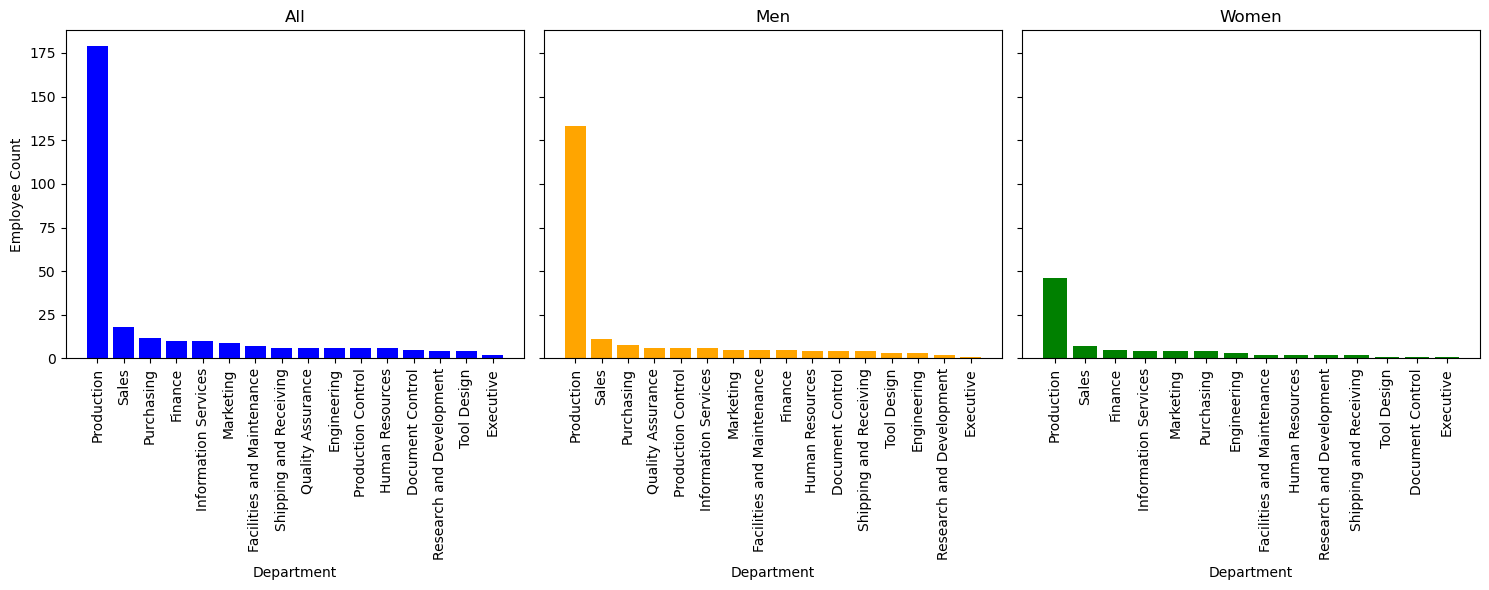

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

axes[0].bar(num_em_per_dep_df["DepartmentName"], num_em_per_dep_df["EmployeeCount"], color='blue')
axes[0].set_title("All")
axes[0].set_xlabel("Department")
axes[0].set_ylabel("Employee Count")
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(num_men_per_dep_df["DepartmentName"], num_men_per_dep_df["EmployeeCount"], color='orange')
axes[1].set_title("Men")
axes[1].set_xlabel("Department")
axes[1].tick_params(axis='x', rotation=90)

axes[2].bar(num_wom_per_dep_df["DepartmentName"], num_wom_per_dep_df["EmployeeCount"], color='green')
axes[2].set_title("Women")
axes[2].set_xlabel("Department")
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()

plt.show()

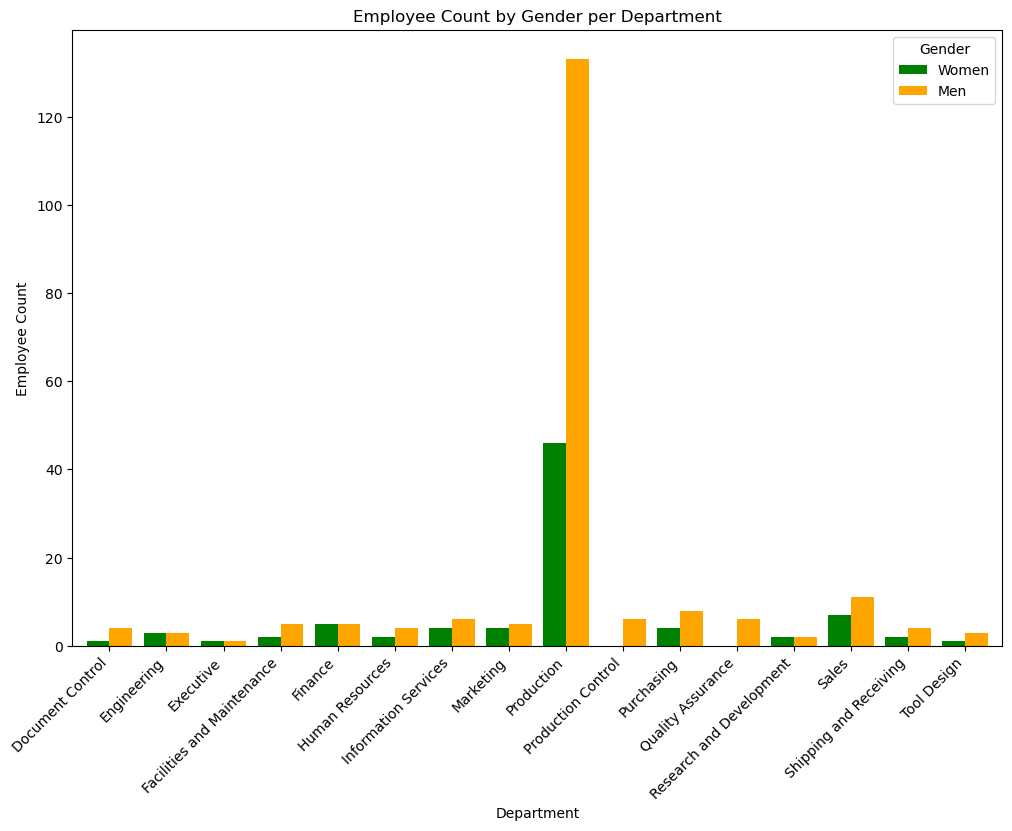

In [65]:
pivot_df = num_gen_per_dep_df.pivot(index='DepartmentName', columns='Gender', values='EmployeeCount')

plt.figure(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=False, width=0.8, color=['green', 'orange'], ax=plt.gca())
plt.xlabel('Department')
plt.ylabel('Employee Count')
plt.title('Employee Count by Gender per Department')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender', labels=['Women', 'Men'])
plt.show()

Här ska jag göra en statistisk analys för att titta på om skillnaden mellan antal män och kvinnor är statistiskt signifikant. (95% konfidensnivå)

In [66]:
total_men = num_men_per_dep_df['EmployeeCount'].sum()
print(f"total_men: {total_men}")
total_wom = num_wom_per_dep_df['EmployeeCount'].sum()
print(f"total_wom: {total_wom}")
n_men = len(num_men_per_dep_df['EmployeeCount'])
print(f"n_men: {n_men}")
n_wom = len(num_wom_per_dep_df['EmployeeCount'])
print(f"n_wom: {n_wom}")
p_men = total_men / (total_men + total_wom)
p_wom = total_wom / (total_men + total_wom)
print(f"p_men: {p_men} och p_wom: {p_wom}")
print(f"Z value enligt z-table: {1.96} för 95% säkerhetsnivå")
z_value = 1.96
std_err = np.sqrt((p_men * (1 - p_wom) / total_men) + (p_wom * (1 - p_wom) / total_wom))
ci_lower = (p_men - p_wom) - z_value * std_err
ci_upper = (p_men - p_wom) + z_value * std_err

print(f"KonfidensInterval: ({ci_lower}, {ci_upper})")
print("\nEftersom konfidensintervallet innehåller inte noll och intervallet är positiv så")
print("vi kan säga att skillnaden mellan antal män och kvinnor är statistiskt signifikant.")
print("vi kan säga att antal anställda män är signifikant fler än kvinnor.\n")



total_men: 206
total_wom: 84
n_men: 16
n_wom: 14
p_men: 0.7103448275862069 och p_wom: 0.2896551724137931
Z value enligt z-table: 1.96 för 95% säkerhetsnivå
KonfidensInterval: (0.28350463815461546, 0.557874672190212)

Eftersom konfidensintervallet innehåller inte noll och intervallet är positiv så
vi kan säga att skillnaden mellan antal män och kvinnor är statistiskt signifikant.
vi kan säga att antal anställda män är signifikant fler än kvinnor.



Vad händer om vi ignorerar "Production" avdelningen.

In [71]:
num_men_per_dep_q_without_production = """
SELECT 
    d.Name AS DepartmentName, 
    e.Gender,
    COUNT(e.BusinessEntityID) AS EmployeeCount
FROM 
    HumanResources.Employee e
JOIN 
    HumanResources.EmployeeDepartmentHistory edh ON e.BusinessEntityID = edh.BusinessEntityID
JOIN 
    HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
WHERE 
    edh.EndDate IS NULL and e.Gender = 'M' and d.Name != 'Production'
GROUP BY 
    d.Name, e.Gender
ORDER BY 
    EmployeeCount DESC;
"""

num_wom_per_dep_q_without_production = """
SELECT 
    d.Name AS DepartmentName, 
    e.Gender,
    COUNT(e.BusinessEntityID) AS EmployeeCount
FROM 
    HumanResources.Employee e
JOIN 
    HumanResources.EmployeeDepartmentHistory edh ON e.BusinessEntityID = edh.BusinessEntityID
JOIN 
    HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
WHERE 
    edh.EndDate IS NULL and e.Gender = 'F' and d.Name != 'Production'
GROUP BY 
    d.Name, e.Gender
ORDER BY 
    EmployeeCount DESC;
"""

num_men_per_dep_df_without_production = pd.read_sql(num_men_per_dep_q_without_production, connection)
num_men_per_dep_df_without_production.head(500)
num_wom_per_dep_df_without_production = pd.read_sql(num_wom_per_dep_q_without_production, connection)
num_wom_per_dep_df_without_production.head(500)



total_men2 = num_men_per_dep_df_without_production['EmployeeCount'].sum()
print(f"total_men: {total_men2}")
total_wom2 = num_wom_per_dep_df_without_production['EmployeeCount'].sum()
print(f"total_wom: {total_wom2}")
n_men2 = len(num_men_per_dep_df_without_production['EmployeeCount'])
print(f"n_men: {n_men2}")
n_wom2 = len(num_wom_per_dep_df_without_production['EmployeeCount'])
print(f"n_wom: {n_wom2}")
p_men2 = total_men2 / (total_men2 + total_wom2)
p_wom2 = total_wom2 / (total_men2 + total_wom2)
print(f"p_men: {p_men2} och p_wom: {p_wom2}")
print(f"Z value enligt z-table: {1.96} för 95% säkerhetsnivå")
z_value2 = 1.96
std_err2 = np.sqrt((p_men2 * (1 - p_wom2) / total_men2) + (p_wom2 * (1 - p_wom2) / total_wom2))
ci_lower2 = (p_men2 - p_wom2) - z_value2 * std_err2
ci_upper2 = (p_men2 - p_wom2) + z_value2 * std_err2

print(f"\nKonfidensInterval när Production är ignorerad: ({ci_lower2}, {ci_upper2})")
print(f"Vi ser att när vi tar bort production avdelningen KIntervallet närmar sig till noll")
print(f"som betyder att skillnaden är mindre signifikant men eftersom noll inte finns i intervallet")
print(f"vi kan fortfarande säga att skillnaden är signifikant.")



total_men: 73
total_wom: 38
n_men: 15
n_wom: 13
p_men: 0.6576576576576577 och p_wom: 0.34234234234234234
Z value enligt z-table: 1.96 för 95% säkerhetsnivå
KonfidensInterval när Production är ignorerad: (0.10195702605184365, 0.5286736045787871)


Nuförtiden nästan alla företag försöker skapa en balans mellan antal män och kvinnor i företag så jag kan rekommendera att
ansvariga för rekryteringen i företaget kan planera att ge bättre möjligheter till kvinnor att de får jobb i detta företag
så att en bra balans mellan antal män och kvinnor blir möjligt.
Jag kan absolut se och förstå skillnaden i Production avdelningen och det kan bero på att män och kvinnor är olika när det 
gäller arbete som kräver mer kraftiga kroppar.
Vi tittade på resultatet utan Production avdelningen att ändå skillnaden är statistiskt signifikant.

Självvärdering

 1. Utmaningar du haft under arbetet samt hur du hanterat dem.

    Jag behövde kolla på olika exemplar från nätet för att skapa diagram.
    Jag skulle göra en statistisk analys över lönen av anställda men det var oklart 
    vad är lönen enligt databasen. Jag hittade bara en tabel som heter "EmployeePayHistory"
    det finns ingen tidlig enhet(per månad/timme/år eller valuta)


 2. Vilket betyg du anser att du skall ha och varför.

    Jag förväntar en VG
    
 3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den